In [0]:
# load required packages
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt 
plt.rcParams['figure.dpi'] = 100
import seaborn as sns 
sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# filter warnings on depreciation etc.
import warnings 
warnings.filterwarnings("ignore")

In [0]:
# code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Loading Data Sets

In [0]:
# load articleBody test data set
link = 'https://drive.google.com/open?id=1R8znLn0TJScdrnhJRTT-kHOHIVewwTlO' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data_train_bodies = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
# check first five rows
data_train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [0]:
# load Headline test data set
link = 'https://drive.google.com/open?id=1FNFwunCI9ubhHMlHhqyzWZE1jht43wN_' # The shareable link
fluff, id = link.split('=')
# loading stances dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data_train_headlines = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
# check first five rows
data_train_headlines.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [0]:
# set up pregress bar
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)

### Basic Properties of the Data Sets

In [0]:
# train articleBody data has 1683 records 
data_train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [0]:
# train articleBody has 2 columns Body ID - unique IDs, articleBody - contains full news article text 
data_train_bodies.columns

Index(['Body ID', 'articleBody'], dtype='object')

In [0]:
# train Headline data has 49972 records 
data_train_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [0]:
# train Headline has 3 columns Headline contains article titles, Body ID - unique IDs, Stance contains our target labels
data_train_headlines.columns

Index(['Headline', 'Body ID', 'Stance'], dtype='object')

In [0]:
# train Headline data has 4 unique stances/labes: unrelated, agree, disagree, discuss
data_train_headlines['Stance'].unique()

array(['unrelated', 'agree', 'disagree', 'discuss'], dtype=object)

In [0]:
# group stances to use them in plot
df_cat = data_train_headlines.groupby('Stance').agg({'Headline': pd.Series.count}).sort_values('Headline', ascending=False) 

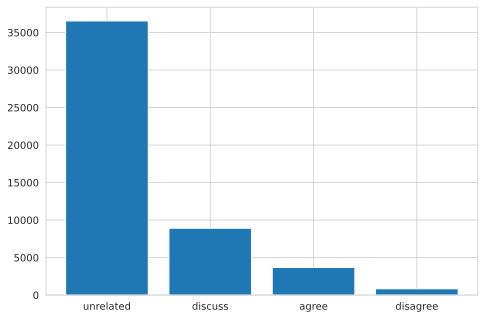

In [0]:
# check distribution of data lables
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_cat.index,df_cat['Headline'])
plt.show()

As the most real-life problems, our dataset has many imbalanced classes. 
Imbalanced data pose classification problem for predictive modelling as most of the machine learning algorithms are used for classification were designed around the assumption of an equal number of examples for each class. As a result, models train on imbalanced data have poor predictive performance specifically on minority class. We are going to explore different data balancing strategies for our dataset.

### Data Cleaning

In [0]:
# remove special caracters and put everything in lower case for both train data sets
for i in range(len(data_train_bodies)):
  data_train_bodies["articleBody"][i]= (data_train_bodies["articleBody"][i].encode('ascii', 'ignore')).decode("utf-8")
  data_train_bodies["articleBody"][i] = data_train_bodies["articleBody"][i].lower()

for i in range(len(data_train_headlines)):
  data_train_headlines["Headline"][i]= (data_train_headlines["Headline"][i].encode('ascii', 'ignore')).decode("utf-8")
  data_train_headlines["Headline"][i] = data_train_headlines["Headline"][i].lower()
  out.update(progress(i, len(data_train_stances)))

In [0]:
# create function for removing special caracters
import html
import re
def clean(s):
    s = html.unescape(s)
    s = s.replace("\\n"," ")
    s = s.replace("_NEG","")
    s = s.replace("_NEGFIRST", "")
    s = re.sub(r"_", "", s)
    s = re.sub(r"#", "", s)
    s = re.sub(r"\*", "", s)
    s = re.sub(r"\'s", "", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r",", "", s)
    s = re.sub(r"!", " !", s)
    s = re.sub(r"\(", "", s)
    s = re.sub(r"\)", "", s)
    s = re.sub(r"\?", " ?", s)
    s = re.sub(r'[^\x00-\x7F]',' ', s)
    s = re.sub(r'[^\w\s]',' ',s)
    s = re.sub("\d+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.rstrip(',|.|;|:|\'|\"')
    s = s.lstrip('\'|\"')

    return str(s)

In [0]:
# apply clean function to data_train_bodies
for i in range(len(data_train_bodies)):
      data_train_bodies["articleBody"][i]= clean(data_train_bodies["articleBody"][i])
      out.update(progress(i, len(data_train_bodies)))

In [0]:
# apply clean function to data_train_headlines
for i in range(len(data_train_headlines)):
      data_train_headlines["Headline"][i]= clean(data_train_headlines["Headline"][i])
      out.update(progress(i, len(data_train_headlines)))

In [0]:
# remove stop words from data_train_bodies 
from gensim.parsing.preprocessing import remove_stopwords

data_train_bodies.loc[:,"articleBody_nostop"] = data_train_bodies.articleBody.apply(lambda x : remove_stopwords(x))

In [0]:
# removing stop words from data_train_headlines 
data_train_headlines.loc[:,"Headline_nostop"] = data_train_headlines.Headline.apply(lambda x : remove_stopwords(x))

In [0]:
data_train_bodies.tail()

,Body ID,articleBody,articleBody_nostop,articleBody_lemma,articleBody_clean
1678,2528,intelligence agencies hunting for identity of ...,intelligence agencies hunting identity jihadis...,intelligence agency hunt identity jihadist mur...,intelligence agency hunt identity jihadist mur...
1679,2529,while daleks know no fear and must not fear th...,daleks know fear fear cold calculating robots ...,dalek know fear fear cold calculating robot dr...,know fear fear cold robot dr series exist real...
1680,2530,more than schoolgirls were kidnapped in april ...,schoolgirls kidnapped april sparking bringback...,schoolgirls kidnap april spark bringbackourgir...,schoolgirls kidnap april spark bringbackourgir...
1681,2531,a guantanamo bay prisoner released last year a...,guantanamo bay prisoner released year exchange...,guantanamo bay prisoner release year exchange ...,guantanamo bay prisoner release year exchange ...
1682,2532,ann arbor mich a pizza delivery man in michiga...,ann arbor mich pizza delivery man michigan got...,ann arbor mich pizza delivery man michigan get...,ann pizza delivery man get huge surprise speci...


In [0]:
data_train_headlines.head()
#data_train_headlines  = data_train_headlines.drop(['Headline_lemma', 'articleBody_lemma'], axis=1)

,Headline,Body ID,Stance,Headline_nostop,Headline_lemma,Headline_clean
0,police find mass graves with at least bodies n...,712,unrelated,police mass graves bodies near mexico town stu...,police mass grave body near mexico town studen...,police mass grave body near mexico town studen...
1,hundreds of palestinians flee floods in gaza a...,158,agree,hundreds palestinians flee floods gaza israel ...,hundred palestinians flee flood gaza israel op...,flood gaza israel open
2,christian bale passes on role of steve jobs ac...,137,unrelated,christian bale passes role steve jobs actor re...,christian bale pass role steve jobs actor repo...,christian bale pass role steve jobs actor repo...
3,hbo and apple in talks for month apple tv stre...,1034,unrelated,hbo apple talks month apple tv streaming servi...,hbo apple talks month apple tv streaming servi...,hbo apple talks month apple tv streaming servi...
4,spider burrowed through tourist stomach and up...,1923,disagree,spider burrowed tourist stomach chest,spider burrow tourist stomach chest,spider burrow tourist stomach chest


In [0]:
# apply lemmatization to both data_train_bodies and data_train_headlines
import spacy
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

In [0]:
data_train_headlines['articleBody_lemma'] = ''
for i in range(0, len(data_train_bodies.articleBody_nostop)):
  doc = lemmatizer(data_train_bodies.articleBody_nostop[i])
  data_train_bodies['articleBody_lemma'][i] = " ".join([token.lemma_ for token in doc])
  out.update(progress(i, len(data_train_bodies))) 

In [0]:
data_train_headlines['Headline_lemma'] = ''
for i in range(0, len(data_train_headlines.Headline_nostop)):
  doc = lemmatizer(data_train_headlines.Headline_nostop[i])
  data_train_headlines['Headline_lemma'][i] = " ".join([token.lemma_ for token in doc])
  out.update(progress(i, len(data_train_headlines))) 

In [0]:
# remove extra stop words
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

corpus_articleBody = data_train_bodies.articleBody_lemma.apply(lambda x : w_tokenizer.tokenize(x))
corpus_articleBody = np.concatenate(corpus_articleBody)
len(corpus_articleBody)

In [0]:
len(corpus_articleBody)

327049

In [0]:
wordfreq_body = dict()
for i in corpus_articleBody:
    if i not in wordfreq_body.keys():
        wordfreq_body[i] = 1
    else:
        wordfreq_body[i] = wordfreq_body[i]+1 

In [0]:
new_stop_body = dict()
for (key, value) in wordfreq_body.items():
  if value <= 10:
    new_stop_body[key] = value

In [0]:
# function to get list from dictionary
def getList(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key)    
    return list

In [0]:
new_stop_list_body = getList(new_stop_body)
len(new_stop_list_body)

15071

In [0]:
corpus_headline = data_train_headlines.Headline_lemma.apply(lambda x : w_tokenizer.tokenize(x))
corpus_headline = np.concatenate(corpus_headline)
len(corpus_headline)

In [0]:
len(corpus_headline)

401419

In [0]:
wordfreq_headline = dict()
for i in corpus_headline:
    if i not in wordfreq_headline.keys():
        wordfreq_headline[i] = 1
    else:
        wordfreq_headline[i] = wordfreq_headline[i]+1 

In [0]:
new_stop_headline = dict()
for (key, value) in wordfreq_headline.items():
  if value <= 50:
    new_stop_headline[key] = value

In [0]:
new_stop_list_headline = getList(new_stop_headline)
len(new_stop_headline)

1355

In [0]:
extra_stop_words = ['s', 'u', 'p', 'm', '-PRON-', 'th', 't', 'st', 'k', 'e', 'c', 'yo', 'il', 'o', 'j']

In [0]:
new_stop_list_body.extend(extra_stop_words)
len(new_stop_list_body)

In [0]:
len(new_stop_list_body)

15086

In [0]:
new_stop_list_headline.extend(extra_stop_words)
len(new_stop_list_headline)

In [0]:
len(new_stop_list_headline)

1370

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# remove extra stop words in articleBody
from nltk.tokenize import word_tokenize
data_train_bodies["articleBody_clean"] =''
for i in range(len(data_train_bodies)):  
    example_sent =  str(data_train_bodies["articleBody_lemma"][i])
    word_tokens = word_tokenize(example_sent)
    filtered_sentence = [w for w in word_tokens if not w in new_stop_list_body] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in new_stop_list_body: 
            filtered_sentence.append(w) 
    data_train_bodies["articleBody_clean"][i] = filtered_sentence
    out.update(progress(i, len(data_train_bodies)))    

In [0]:
# remove extra stop words in Headline
from nltk.tokenize import word_tokenize
data_train_headlines["Headline_clean"] =''
for i in range(len(data_train_headlines)):  
    example_sent =  str(data_train_headlines["Headline_lemma"][i])
    word_tokens = word_tokenize(example_sent)
    filtered_sentence = [w for w in word_tokens if not w in new_stop_list_headline] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in new_stop_list_headline: 
            filtered_sentence.append(w) 
    data_train_headlines["Headline_clean"][i] = filtered_sentence
    out.update(progress(i, len(data_train_headlines)))    

In [0]:
def listToString(s):  
  str1 = " "
  return (str1.join(s)) 

In [0]:
data_train_headlines.loc[:,"Headline_clean"] = data_train_headlines.Headline_clean.apply(lambda x : listToString(x))
data_train_bodies.loc[:,"articleBody_clean"] = data_train_bodies.articleBody_clean.apply(lambda x : listToString(x))

In [0]:
# mounting drive for clean dataframe
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# save both dataframes as csv files
data_train_headlines.to_csv('drive/My Drive/Colab Notebooks/headline_clean_train.csv')


In [0]:
data_train_bodies.to_csv('drive/My Drive/Colab Notebooks/body_clean_train.csv')


### Feature Engineering


#### Semantic Extraction for Article Headline and Article Body

In [0]:
# Install stanza; note that the prefix "!" is not needed if you are running in a terminal
#!pip install stanza==1.0.0

# Import stanza
import stanza

     |████████████████████████████████| 194kB 2.8MB/s 


In [0]:
# Download the Stanford CoreNLP Java library and unzip it to a ./corenlp folder
!echo "Downloading CoreNLP..."
!wget "http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip" -O corenlp.zip
!unzip corenlp.zip
!mv ./stanford-corenlp-full-2018-10-05 ./corenlp

# Set the CORENLP_HOME environment variable to point to the installation location
import os
os.environ["CORENLP_HOME"] = "./corenlp"

--2020-04-11 16:27:36--  http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip [following]
--2020-04-11 16:27:36--  https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393239982 (375M) [application/zip]
Saving to: ‘corenlp.zip’

corenlp.zip         100%[===================>] 375.02M  16.8MB/s    in 16s     

2020-04-11 16:27:52 (23.5 MB/s) - ‘corenlp.zip’ saved [393239982/393239982]

Archive:  corenlp.zip
   creating: stanford-corenlp-full-2018-10-05/
  inflating: stanford-corenlp-full-2018-10-05/jaxb-core-2.3.0.1-sources.jar  
  inflating: stan

In [0]:
# Import client module
from stanza.server import CoreNLPClient

In [0]:
# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(annotators=['sentiment'], memory='4G', endpoint='http://localhost:9001')
print(client)

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()

Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2473c99a9f1c4b31.props -preload sentiment


In [0]:
#data_train_bodies = data_train_bodies.drop(['articleBody_clean_1'], axis=1)
data_train_bodies.tail()

,Body ID,articleBody,articleBody_nostop,articleBody_lemma,articleBody_clean,articleBody_sentiment,articleBody_clean_truncated
1678,2528,intelligence agencies hunting for identity of ...,intelligence agencies hunting identity jihadis...,intelligence agency hunt identity jihadist mur...,intelligence agency hunt identity jihadist mur...,Verynegative,intelligence agency hunt identity jihadist mur...
1679,2529,while daleks know no fear and must not fear th...,daleks know fear fear cold calculating robots ...,dalek know fear fear cold calculating robot dr...,know fear fear cold robot dr series exist real...,Negative,know fear fear cold robot dr series exist real...
1680,2530,more than schoolgirls were kidnapped in april ...,schoolgirls kidnapped april sparking bringback...,schoolgirls kidnap april spark bringbackourgir...,schoolgirls kidnap april spark bringbackourgir...,Negative,schoolgirls kidnap april spark bringbackourgir...
1681,2531,a guantanamo bay prisoner released last year a...,guantanamo bay prisoner released year exchange...,guantanamo bay prisoner release year exchange ...,guantanamo bay prisoner release year exchange ...,Verynegative,guantanamo bay prisoner release year exchange ...
1682,2532,ann arbor mich a pizza delivery man in michiga...,ann arbor mich pizza delivery man michigan got...,ann arbor mich pizza delivery man michigan get...,ann pizza delivery man get huge surprise speci...,Negative,ann pizza delivery man get huge surprise speci...


In [0]:
# truncate articleBody to max 100 words
data_train_bodies['articleBody_clean_truncated'] = ''
for i in range(len(data_train_bodies['articleBody_clean'])):
  if len(data_train_bodies['articleBody_clean'][i]) > 0:
    truncate = data_train_bodies['articleBody_clean'][i].split()
    data_train_bodies['articleBody_clean_truncated'][i] = truncate[0:100]
    out.update(progress(i, len(data_train_bodies)))

data_train_bodies.loc[:,"articleBody_clean_truncated"] = data_train_bodies.articleBody_clean_truncated.apply(lambda x : listToString(x))

In [0]:
data_train_headlines.head()

,Headline,Body ID,Stance,Headline_nostop,Headline_lemma,Headline_clean,Headline_sentiment
0,police find mass graves with at least bodies n...,712,unrelated,police mass graves bodies near mexico town stu...,police mass grave body near mexico town studen...,police mass grave body near mexico town studen...,Negative
1,hundreds of palestinians flee floods in gaza a...,158,agree,hundreds palestinians flee floods gaza israel ...,hundred palestinians flee flood gaza israel op...,flood gaza israel open,Neutral
2,christian bale passes on role of steve jobs ac...,137,unrelated,christian bale passes role steve jobs actor re...,christian bale pass role steve jobs actor repo...,christian bale pass role steve jobs actor repo...,Negative
3,hbo and apple in talks for month apple tv stre...,1034,unrelated,hbo apple talks month apple tv streaming servi...,hbo apple talks month apple tv streaming servi...,hbo apple talks month apple tv streaming servi...,Negative
4,spider burrowed through tourist stomach and up...,1923,disagree,spider burrowed tourist stomach chest,spider burrow tourist stomach chest,spider burrow tourist stomach chest,Negative


In [0]:
sentence = client.annotate(data_train_bodies.articleBody_clean[1], properties={ 'annotators': 'sentiment', 'outputFormat': 'json',})

for s in sentence["sentences"]:
  print(s["sentiment"])

Negative


In [0]:
# create sentiment from articleBody
data_train_bodies['articleBody_sentiment'] = ''
for i in range(len(data_train_bodies)):
  sentence = client.annotate(data_train_bodies.articleBody_clean_truncated[i], properties={ 'annotators': 'sentiment', 'outputFormat': 'json',})
  for s in sentence["sentences"]:
    data_train_bodies["articleBody_sentiment"][i] = s["sentiment"]
    out.update(progress(i, len(data_train_bodies))) 

In [0]:
# create sentiment from Headline
data_train_headlines['Headline_sentiment'] = ''
for i in range(len(data_train_headlines)):
  sentence = client.annotate(data_train_headlines.Headline_clean[i], properties={ 'annotators': 'sentiment', 'outputFormat': 'json',})
  for s in sentence["sentences"]:
    data_train_headlines["Headline_sentiment"][i] = s["sentiment"]
    out.update(progress(i, len(data_train_headlines))) 

In [0]:
# save both dataframes as csv files
data_train_headlines.to_csv('drive/My Drive/Colab Notebooks/headline_sentiment_train.csv')

In [0]:
data_train_bodies.to_csv('drive/My Drive/Colab Notebooks/body_sentiment_train.csv')

#### Question Mark in Headline

In [0]:
# load articleBody test data set
link = 'https://drive.google.com/open?id=1-NtTKFcheteva_36o5eyh-b-ljPpkDjW' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
# load articleBody test data set
link = 'https://drive.google.com/open?id=1FNFwunCI9ubhHMlHhqyzWZE1jht43wN_' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df_headline = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
# load articleBody test data set
link = 'https://drive.google.com/open?id=1-B5ynPUeRt4r8m8an63NsvFfqOyfaLAu' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
head_sen = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
# load articleBody test data set
link = 'https://drive.google.com/open?id=1-KFa1kthRuP07nqLw2_isPI45dc3K_P4' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
article_sen = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
article_sen.tail()

,Unnamed: 0,Body ID,articleBody,articleBody_nostop,articleBody_lemma,articleBody_clean,articleBody_sentiment,articleBody_clean_truncated
1678,1678,2528,intelligence agencies hunting for identity of ...,intelligence agencies hunting identity jihadis...,intelligence agency hunt identity jihadist mur...,intelligence agency hunt identity jihadist mur...,Verynegative,intelligence agency hunt identity jihadist mur...
1679,1679,2529,while daleks know no fear and must not fear th...,daleks know fear fear cold calculating robots ...,dalek know fear fear cold calculating robot dr...,know fear fear cold robot dr series exist real...,Negative,know fear fear cold robot dr series exist real...
1680,1680,2530,more than schoolgirls were kidnapped in april ...,schoolgirls kidnapped april sparking bringback...,schoolgirls kidnap april spark bringbackourgir...,schoolgirls kidnap april spark bringbackourgir...,Negative,schoolgirls kidnap april spark bringbackourgir...
1681,1681,2531,a guantanamo bay prisoner released last year a...,guantanamo bay prisoner released year exchange...,guantanamo bay prisoner release year exchange ...,guantanamo bay prisoner release year exchange ...,Verynegative,guantanamo bay prisoner release year exchange ...
1682,1682,2532,ann arbor mich a pizza delivery man in michiga...,ann arbor mich pizza delivery man michigan got...,ann arbor mich pizza delivery man michigan get...,ann pizza delivery man get huge surprise speci...,Negative,ann pizza delivery man get huge surprise speci...


In [0]:
df['Headline'] = df_headline['Headline']
df['Headline_sentiment'] = head_sen['Headline_sentiment']

In [0]:
# adding articleBody_sentiment to main data frame
df["articleBody_sentiment"]=''
for i in range(len(df)):
  for j in range(len(article_sen)):
    if (article_sen["Body ID"][j]==df["Body ID"][i]):
      df["articleBody_sentiment"][i]=article_sen["articleBody_sentiment"][j]
      out.update(progress(i, len(df)))

In [0]:
df.tail()
#df = df.drop('Unnamed: 0', axis=1)

,Body ID,Stance,Headline_clean,articleBody,Headline,Headline_sentiment,articleBody_sentiment,question_mark,word_overlap,cosine_similarity
49940,1681,unrelated,urgent leader isil abu bakr al baghdadi kill p...,cnn boko haram laugh nigeria announcement ceas...,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,Negative,Negative,0,0.629630,0.017174
49941,2419,unrelated,brian williams social media weatherman mike se...,unveil apple watch early year company announce...,Brian Williams slams social media for speculat...,Negative,Negative,0,0.739130,0.000000
49942,1156,agree,mexico say miss student mass grave,mass grave confirm miss student,Mexico Says Missing Students Not Found In Firs...,Neutral,Negative,0,0.833333,0.436038
49943,1012,discuss,lawmaker isis fighter apprehend come southern ...,rep duncan hunter r ca tell greta van susteren...,US Lawmaker: Ten ISIS Fighters Have Been Appre...,Negative,Negative,0,0.846154,0.289841
49944,2044,unrelated,shot hear allege brown shooting recording audio,married tv actor meet young woman wake testicl...,Shots Heard In Alleged Brown Shooting Recordin...,Neutral,Negative,0,0.739130,0.000000


In [0]:
import re

question_mark = []
for i in range(len(df)):
  if '?' in df.Headline[i]:
    question = 1
    question_mark.append(question)
  else:
    question = 0 
    question_mark.append(question)

In [0]:
df['question_mark'] = question_mark

#### Creating Word Overlap

In [0]:
df = df.dropna()

In [0]:
df = df.reset_index(drop=True)

In [0]:
df.isna().sum()

Body ID                  0
Stance                   0
Headline_clean           0
articleBody              0
Headline                 0
Headline_sentiment       0
articleBody_sentiment    0
question_mark            0
dtype: int64

In [0]:
df['Headline_clean'][10]


'woman detain lebanon al baghdadi wife iraq say'

In [0]:
word_overlap = []
for i in range(len(df)):
  features = len(set(df.Headline_clean[i]).intersection(df.articleBody[i])) / float(len(set(df.Headline_clean[i]).union(df.articleBody[i])))
  word_overlap.append(features)

In [0]:
df['word_overlap'] = word_overlap

#### Extracting Cosine Similarities

In [0]:
def extract_cosine_similarity(headlines, bodies):
    vectorizer = TfidfVectorizer(ngram_range=(1,2))

    cos_sim_features = []
    for i in range(0, len(bodies)):
        body_vs_headline = []
        body_vs_headline.append(bodies[i])
        body_vs_headline.append(headlines[i])
        tfidf = vectorizer.fit_transform(body_vs_headline)
        
        cosine_similarity = (tfidf * tfidf.T).A
        cos_sim_features.append(cosine_similarity[0][1])

    cos_sim_array = np.array(cos_sim_features)

    return cos_sim_array

In [0]:
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from scipy import sparse

In [0]:
cosine_similarity = extract_cosine_similarity(df.Headline_clean, df.articleBody)

In [0]:
df['cosine_similarity'] = cosine_similarity

In [0]:
# mounting drive for clean dataframe
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# save both dataframes as csv files
df.to_csv('drive/My Drive/Colab Notebooks/clean_train_features_final.csv')

### Feature Extraction

In [0]:
# load clean data set
link = 'https://drive.google.com/open?id=1-2AIUqFkwqgFhWHUTX33Q_v5oSOBKAU9' # The shareable link
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
df = df.drop(['Headline' , 'Unnamed: 0'], axis=1)
df.tail()

,Body ID,Stance,Headline_clean,articleBody,Headline_sentiment,articleBody_sentiment,question_mark,word_overlap,cosine_similarity
49940,1681,unrelated,urgent leader isil abu bakr al baghdadi kill p...,cnn boko haram laugh nigeria announcement ceas...,Negative,Negative,0,0.629630,0.017174
49941,2419,unrelated,brian williams social media weatherman mike se...,unveil apple watch early year company announce...,Negative,Negative,0,0.739130,0.000000
49942,1156,agree,mexico say miss student mass grave,mass grave confirm miss student,Neutral,Negative,0,0.833333,0.436038
49943,1012,discuss,lawmaker isis fighter apprehend come southern ...,rep duncan hunter r ca tell greta van susteren...,Negative,Negative,0,0.846154,0.289841
49944,2044,unrelated,shot hear allege brown shooting recording audio,married tv actor meet young woman wake testicl...,Neutral,Negative,0,0.739130,0.000000


#### Bag-of-Words Model

In [0]:
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', lowercase=False)

In [0]:
articleBody_BOW = cv.fit_transform(df['articleBody'])
Headline_BOW = cv.fit_transform(df['Headline_clean'])
combined_BOW = sp.hstack([Headline_BOW, articleBody_BOW], format='csr')

#### TF-IDF Model

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', lowercase=False)

In [0]:
articleBody_TFIDF = tfidf.fit_transform(df['articleBody'])
Headline_TFIDF = tfidf.fit_transform(df['Headline_clean'])
combined_TFIDF = sp.hstack([Headline_TFIDF, articleBody_TFIDF, ], format='csr')

### Feature Selection

#### Univariate Selection BOW

In [0]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


X = combined_BOW
Y = df.Stance

# feature extraction
test = SelectKBest(score_func=f_classif, k=1000)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=8)
features_1000 = fit.transform(X)

#### Univariate Selection TFIDF

In [0]:
X = combined_TFIDF
Y = df.Stance

# feature extraction
test = SelectKBest(score_func=f_classif, k=1000)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=8)
features_1000_TFIDF = fit.transform(X)

#### Feature Importance BOW

In [0]:
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

X = combined_BOW
Y = df.Stance

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[1.692e-04 2.679e-04 8.137e-05 ... 0.000e+00 4.396e-05 1.228e-05]


### Word Embadings

####  Bigrams

In [0]:
from gensim.models.phrases import Phrases, Phraser
words_headline = [row.split() for row in df['Headline_clean']]
words_body = [row.split() for row in df['articleBody']]
words = words_headline + words_body

# creating relevant phrases
phrases = Phrases(words, min_count=20, threshold=80)

# creating bigrams
bigrams = Phraser(phrases)

dictionary = bigrams[words]

#### Word2Vec


*   min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
*   window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

*   size = int - Dimensionality of the feature vectors. - (50, 300)

*   sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
*   Lalpha = float - The initial learning rate - (0.01, 0.05)


*   min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

*   negative = int - If > 0, negative sampling will be used, the int for negative 
*   specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)



In [0]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

# Building vocabulary
w2v_model.build_vocab(dictionary, progress_per=10000)

# Building model
w2v_model.train(dictionary, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

w2v_model.most_similar(positive=["isis"])

#### GloVe

In [0]:
!pip install glove_python

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700245 sha256=fff10492a01dbafa18999826e4a012f4e5cc6a02fac03b0c0a426eab322dfca6
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
sentences =  df.articleBody.apply(lambda x : w_tokenizer.tokenize(x))

In [0]:
sentences

0        [danny, boyle, direct, film, seth, rogen, play...
1        [evacuate, home, sunday, morning, israeli, aut...
2        [year, old, moscow, resident, hospitalize, wou...
3        [reuters, canadian, soldier, shoot, canadian, ...
4        [fear, story, bunbury, scientist, cast, doubt,...
                               ...                        
49940    [cnn, boko, haram, laugh, nigeria, announcemen...
49941    [unveil, apple, watch, early, year, company, a...
49942                [mass, grave, confirm, miss, student]
49943    [rep, duncan, hunter, r, ca, tell, greta, van,...
49944    [married, tv, actor, meet, young, woman, wake,...
Name: articleBody, Length: 49945, dtype: object

In [0]:
import itertools
from glove import Corpus, Glove

corpus_articleBody = Corpus()

corpus_articleBody.fit(sentences, window=10)
glove_articleBody = Glove(no_components=100, learning_rate=0.05)
glove_articleBody.fit(corpus_articleBody.matrix, epochs=10, no_threads=4, verbose=True)
glove_articleBody.add_dictionary(corpus_articleBody.dictionary)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [0]:
glove_articleBody.most_similar('man')

[('homeless', 0.5878744570151004),
 ('mask', 0.5694066680595435),
 ('black', 0.5674875684227368),
 ('unidentified', 0.5501288943581739)]

In [0]:
#glove_articleBody.dictionary

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=150)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('classifier', lr)
])

In [0]:
#algo_cv(5, glove_articleBody.word_vectors, df.Stance, original_pipeline, 'macro')

### Baseline Model

#### Bag of Words/Logistic Regression with Imbalanced Data



In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr = LogisticRegression(solver="lbfgs", max_iter=150)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [0]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('classifier', lr)
])

In [0]:
def algo_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        algo_fit = pipeline.fit(X[train], Y[train])
        prediction = algo_fit.predict(X[test])
        scores = algo_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              agree     disagree   discuss   unrelated')
        print('precision:',precision_score(Y[test],    prediction,    average=None))
        recall.append(recall_score(Y[test],    prediction,    average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [0]:
algo_cv(5, combined_BOW, df.Stance, original_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.65965583 0.48181818 0.79192073 0.86685728]
recall:    [0.46938776 0.31547619 0.58370787 0.95442102]
f1 score:  [0.54848967 0.38129496 0.67205692 0.9085342 ]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.65085389 0.50877193 0.78059701 0.86388611]
recall:    [0.46603261 0.3452381  0.58764045 0.94702259]
f1 score:  [0.54315123 0.41134752 0.67051282 0.90354601]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.68257261 0.4952381  0.81877551 0.86131833]
recall:    [0.44761905 0.30952381 0.56316676 0.96413415]
f1 score:  [0.54067379 0.38095238 0.667332   0.90983077]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.64056225 0.43925234 0.75161987 0.86529081]
recall:    [0.43401361 0.2797619  0.58618754 0.94702259]


#### Bag of Words/Logistic Regression with Class Weight (Balanced)



In [0]:
lr_weight = LogisticRegression(C = 1.0, class_weight='balanced', solver="lbfgs", max_iter=150)

from sklearn.pipeline import Pipeline
original_pipeline_weight = Pipeline([
    ('classifier', lr_weight)
])

algo_cv(5, combined_BOW, df.Stance, original_pipeline_weight, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.36065574 0.29095355 0.54102259 0.92660882]
recall:    [0.74829932 0.70833333 0.76685393 0.70161511]
f1 score:  [0.48672566 0.41247834 0.63444109 0.79856675]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36655518 0.27654321 0.52545027 0.92231256]
recall:    [0.74456522 0.66666667 0.75393258 0.69883641]
f1 score:  [0.49125952 0.39092496 0.61928934 0.79517134]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.3557881  0.29176471 0.51979814 0.92178055]
recall:    [0.74013605 0.73809524 0.75182482 0.68884326]
f1 score:  [0.48056537 0.41821248 0.6146431  0.78846757]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.34692557 0.24557522 0.53118946 0.93106635]
recall:    [0.7292517  0.66071429 0.76979225 0.68966461]


#### Bag of Words/Logistic Regression Balanced with SMOTE

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=777, k_neighbors=1)

from imblearn.pipeline import make_pipeline
SMOTE_pipeline = make_pipeline(SMOTE(random_state=777),lr)

algo_cv(5, combined_BOW, df.Stance, SMOTE_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.41640043 0.29328622 0.60426929 0.87521614]
recall:    [0.53197279 0.49404762 0.62022472 0.83137148]
f1 score:  [0.46714456 0.36807095 0.61214306 0.85273059]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.42033543 0.30740741 0.59289617 0.87440519]
recall:    [0.54483696 0.49404762 0.60955056 0.83011636]
f1 score:  [0.47455621 0.37899543 0.60110803 0.85168539]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.44730942 0.30980392 0.59039396 0.87280011]
recall:    [0.54285714 0.4702381  0.61426165 0.83504449]
f1 score:  [0.49047326 0.37352246 0.60209136 0.85350497]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.39978332 0.29277567 0.56840551 0.87904298]
recall:    [0.50204082 0.45833333 0.64851207 0.81478439]


#### Bag of Words/Logistic Regression Balanced with Under Sampler



In [0]:
from imblearn.under_sampling import RandomUnderSampler
under_pipeline = make_pipeline(RandomUnderSampler(random_state=777),lr)
algo_cv(5, combined_BOW, df.Stance, under_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.2311272  0.13184584 0.36261491 0.87052275]
recall:    [0.60816327 0.77380952 0.59831461 0.49233507]
f1 score:  [0.33495691 0.22530329 0.45155819 0.62895611]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.22794899 0.14937286 0.37160752 0.8677686 ]
recall:    [0.58288043 0.7797619  0.6        0.5174538 ]
f1 score:  [0.32773109 0.2507177  0.45896003 0.6483149 ]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.20593692 0.14794216 0.36653806 0.87117316]
recall:    [0.60408163 0.79166667 0.58674902 0.48692676]
f1 score:  [0.30716015 0.24929709 0.45120898 0.62469266]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.21178821 0.13854167 0.38224767 0.87526577]
recall:    [0.57687075 0.79166667 0.59966311 0.50718686]


#### Bag of Words/Logistic Regression Balanced with Over Sampler

In [0]:
from imblearn.over_sampling import RandomOverSampler
over_pipeline = make_pipeline(RandomOverSampler(random_state=777),lr)
algo_cv(5, combined_BOW, df.Stance, over_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.35855263 0.29396985 0.53956835 0.92386425]
recall:    [0.7414966  0.69642857 0.75842697 0.70421571]
f1 score:  [0.48337029 0.41342756 0.63054647 0.7992233 ]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36873747 0.28388747 0.53574297 0.92158261]
recall:    [0.75       0.66071429 0.7494382  0.70787132]
f1 score:  [0.49440215 0.39713775 0.62482436 0.80071229]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36486486 0.29166667 0.52367463 0.91367673]
recall:    [0.73469388 0.70833333 0.72655811 0.70417522]
f1 score:  [0.48758465 0.41319444 0.60865475 0.79536142]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.35153129 0.25641026 0.5254173  0.93028403]
recall:    [0.71836735 0.6547619  0.777653   0.69048597]


#### Bag of Words/Logistic Regression with Univariate Selection

In [0]:
algo_cv(5, features_1000, df.Stance, original_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.62745098 0.44736842 0.73173077 0.8230419 ]
recall:    [0.26122449 0.20238095 0.42752809 0.96509718]
f1 score:  [0.36887608 0.27868852 0.53971631 0.88842689]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.65492958 0.46875    0.75599583 0.81884393]
recall:    [0.25271739 0.26785714 0.40730337 0.96960986]
f1 score:  [0.36470588 0.34090909 0.52939029 0.88787214]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.58769231 0.45054945 0.77268094 0.82192737]
recall:    [0.25986395 0.24404762 0.42560359 0.96673511]
f1 score:  [0.36037736 0.31660232 0.54887762 0.88846952]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.54938272 0.3902439  0.70458891 0.81984304]
recall:    [0.24217687 0.19047619 0.41381246 0.95811088]


#### TF-IDF/Logistic Regression with Imbalanced Data

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, original_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.74021352 0.6031746  0.78493648 0.82804635]
recall:    [0.2829932  0.22619048 0.48595506 0.96824528]
f1 score:  [0.40944882 0.32900433 0.60027759 0.89267462]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.73883162 0.64285714 0.79005525 0.82702197]
recall:    [0.29211957 0.21428571 0.48202247 0.96865161]
f1 score:  [0.41869523 0.32142857 0.59874389 0.89225143]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.79069767 0.61702128 0.80911681 0.82929669]
recall:    [0.32380952 0.17261905 0.47838293 0.97494867]
f1 score:  [0.45945946 0.26976744 0.60127029 0.89624363]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.71717172 0.56862745 0.74955908 0.82696603]
recall:    [0.28979592 0.17261905 0.47725997 0.96303901]


#### TF-IDF/Logistic Regression Class Weight (Balanced)

In [0]:
lr_weight = LogisticRegression(C = 1.0, class_weight='balanced', solver="lbfgs", max_iter=150)

from sklearn.pipeline import Pipeline
original_pipeline_weight = Pipeline([
    ('classifier', lr_weight)
])

algo_cv(5, combined_TFIDF, df.Stance, original_pipeline_weight, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.34591584 0.2832981  0.52608048 0.93788344]
recall:    [0.76054422 0.79761905 0.79325843 0.66958664]
f1 score:  [0.47554232 0.41809672 0.63261649 0.78134483]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.33293839 0.26838966 0.51395793 0.93169979]
recall:    [0.76358696 0.80357143 0.75505618 0.66105407]
f1 score:  [0.46369637 0.4023845  0.6116041  0.77338245]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.35238693 0.29878049 0.50814086 0.92705167]
recall:    [0.76326531 0.875      0.75350926 0.66803559]
f1 score:  [0.48216588 0.44545455 0.60696517 0.77651364]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.33091349 0.25708502 0.51787017 0.94235294]
recall:    [0.74421769 0.75595238 0.79730488 0.65790554]


#### TF-IDF/Logistic Regression Balanced with SMOTE

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=777, k_neighbors=1)

from imblearn.pipeline import make_pipeline
SMOTE_pipeline = make_pipeline(SMOTE(random_state=777),lr)

algo_cv(5, combined_TFIDF, df.Stance, SMOTE_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.37656904 0.31486146 0.55894309 0.92418392]
recall:    [0.73469388 0.74404762 0.77247191 0.72077744]
f1 score:  [0.49792531 0.44247788 0.64858491 0.80990464]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36870748 0.30964467 0.53972828 0.91731039]
recall:    [0.73641304 0.72619048 0.73651685 0.71526352]
f1 score:  [0.49138713 0.4341637  0.62295082 0.80378432]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.38088445 0.355      0.53934899 0.91423611]
recall:    [0.72653061 0.8452381  0.73498035 0.72087611]
f1 score:  [0.49976603 0.5        0.62214829 0.80612323]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36451169 0.28826531 0.54573886 0.93178156]
recall:    [0.72108844 0.67261905 0.78382931 0.71238877]


#### TF-IDF/Logistic Regression Balanced with Under Sampler


In [0]:
from imblearn.under_sampling import RandomUnderSampler
under_pipeline = make_pipeline(RandomUnderSampler(random_state=777),lr)
algo_cv(5, combined_TFIDF, df.Stance, under_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.19197047 0.13384321 0.36977058 0.88772298]
recall:    [0.56598639 0.83333333 0.61573034 0.46318095]
f1 score:  [0.28669883 0.2306425  0.46205734 0.60874258]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.19550252 0.14327772 0.36347946 0.88289676]
recall:    [0.57880435 0.86904762 0.59157303 0.47063655]
f1 score:  [0.2922813  0.24599832 0.45028865 0.61398339]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.20442238 0.14060964 0.36529827 0.90296866]
recall:    [0.61632653 0.85119048 0.63952835 0.44969199]
f1 score:  [0.30701457 0.24135021 0.46499286 0.60038381]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.19041158 0.13047445 0.36003956 0.89750617]
recall:    [0.57278912 0.85119048 0.61313869 0.44832307]


#### TF-IDF/Logistic Regression Balanced with Over Sampler

In [0]:
from imblearn.over_sampling import RandomOverSampler
over_pipeline = make_pipeline(RandomOverSampler(random_state=777),lr)
algo_cv(5, combined_TFIDF, df.Stance, over_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.3693634  0.32330827 0.54139641 0.93023256]
recall:    [0.75782313 0.76785714 0.79719101 0.69531892]
f1 score:  [0.49665626 0.45502646 0.64485344 0.79580168]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36517219 0.31930693 0.53815737 0.92586551]
recall:    [0.76358696 0.76785714 0.76460674 0.69924709]
f1 score:  [0.49406593 0.45104895 0.63170109 0.79675558]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.38209159 0.34634146 0.53212074 0.92353579]
recall:    [0.76054422 0.8452381  0.77203818 0.69938398]
f1 score:  [0.50864422 0.49134948 0.63001145 0.79598037]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.3586025  0.28941176 0.53901515 0.93674866]
recall:    [0.74013605 0.73214286 0.79898933 0.69336071]


#### TFIDF/Logistic Regression with Univariate Selection

In [0]:
algo_cv(5, features_1000_TFIDF, df.Stance, original_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.67021277 0.54545455 0.71465296 0.78665786]
recall:    [0.08571429 0.10714286 0.31235955 0.97810019]
f1 score:  [0.15199035 0.17910448 0.43471462 0.87199512]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.76744186 0.6        0.73167539 0.78569859]
recall:    [0.08967391 0.125      0.31404494 0.97919233]
f1 score:  [0.16058394 0.20689655 0.43946541 0.87183863]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.71       0.59375    0.71719745 0.78527337]
recall:    [0.09659864 0.11309524 0.31611454 0.97522245]
f1 score:  [0.17005988 0.19       0.43881528 0.87000061]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.62385321 0.57142857 0.7076326  0.78384328]
recall:    [0.09251701 0.07142857 0.30713083 0.97494867]


In [0]:
# load clean data set
link = 'https://drive.google.com/open?id=1gaasRgoXGWRcnrIzuYHSCrraIgMV-1me' # The shareable link
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
df['sentiment'] = np.nan
for i in range(len(df.Headline_sentiment)):
  if df.Headline_sentiment[i] == df.articleBody_sentiment[i]:
    df['sentiment'][i] = 1
  else:
    df['sentiment'][i] = 0

In [0]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1)
df.head()

,Body ID,Stance,Headline_clean,articleBody,Headline,Headline_sentiment,articleBody_sentiment,question_mark,word_overlap,cosine_similarity,cross,match,sentiment
0,712,unrelated,police mass grave body near mexico town studen...,danny boyle direct film seth rogen play apple ...,Police find mass graves with at least '15 bodi...,Negative,Negative,0,0.769231,0.000000,0.033333,0,1.0
1,158,agree,flood gaza israel open,evacuate home sunday morning israeli authority...,Hundreds of Palestinians flee floods in Gaza a...,Neutral,Negative,0,0.538462,0.237815,0.300000,1,0.0
2,137,unrelated,christian bale pass role steve jobs actor repo...,year old moscow resident hospitalize wound int...,"Christian Bale passes on role of Steve Jobs, a...",Negative,Negative,0,0.769231,0.000000,0.266667,0,1.0
3,1034,unrelated,hbo apple talks month apple tv streaming servi...,reuters canadian soldier shoot canadian war me...,HBO and Apple in Talks for $15/Month Apple TV ...,Negative,Negative,0,0.826087,0.000000,0.166667,0,1.0
4,1923,disagree,spider burrow tourist stomach chest,fear story bunbury scientist cast doubt claim ...,Spider burrowed through tourist's stomach and ...,Negative,Negative,0,0.615385,0.091232,0.400000,1,1.0


### Feature Selection for New Engineered Features


In [0]:
# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# load data


X = df[['question_mark', 'word_overlap', 'cosine_similarity', 'cross', 'match', 'sentiment']]
Y = df.Stance


# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=8)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[3.62596907e+01 5.87153322e+01 2.91857180e+04 4.05252410e-01
 5.97316848e+00 1.51923460e+01]
[[0.         0.76923077 0.         1.        ]
 [0.         0.53846154 0.23781525 0.        ]
 [0.         0.76923077 0.         1.        ]
 [0.         0.82608696 0.         1.        ]
 [0.         0.61538462 0.09123208 1.        ]]


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


X = df[['question_mark', 'word_overlap', 'cosine_similarity', 'cross', 'match', 'sentiment']]
Y = df.Stance
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True  True  True False False False]
Feature Ranking: [1 1 1 2 4 3]


In [0]:
from sklearn.decomposition import PCA
X = df[['question_mark', 'word_overlap', 'cosine_similarity', 'cross', 'match', 'sentiment']]
Y = df.Stance
# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.408 0.394 0.109]
[[-1.430e-02  5.856e-02 -2.487e-03  3.842e-03 -3.220e-01  9.448e-01]
 [-6.509e-03 -1.575e-02 -9.708e-04  4.104e-04 -9.467e-01 -3.218e-01]
 [ 9.995e-01 -2.386e-02  7.663e-03 -5.043e-03 -1.088e-02  1.294e-02]]


In [0]:
from sklearn.ensemble import ExtraTreesClassifier
X = df[['question_mark', 'word_overlap', 'cosine_similarity', 'cross', 'match', 'sentiment']]
Y = df.Stance
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[0.002 0.125 0.785 0.084 0.002 0.001]


Based on feature selection analysis we decided to select the following features "word_overlap" and "cosine_similarity" since they have higher importance.

### BOW with New Features

In [0]:
from scipy.sparse import coo_matrix
p1 = coo_matrix(df.word_overlap)
p2 = coo_matrix(df.cosine_similarity)

In [0]:
combined_features_BOW = sp.hstack([Headline_BOW, articleBody_BOW, p1.T, p2.T], format='csr')

### TF-IDF with New Features

In [0]:
combined_features_TFIDF = sp.hstack([Headline_TFIDF, articleBody_TFIDF, p1.T, p2.T], format='csr')

------------------------

### New Models

#### TF-IDF/SVM with Extra Features (Over Sampled)

In [0]:
# Creating a small subsample for GridSearch
df1 = df.loc[df['Stance'] == 'agree'].sample(800)
df2 = df.loc[df['Stance'] == 'discuss'].sample(800)
df3 = df.loc[df['Stance'] == 'disagree'].sample(800) 
df4 = df[df.Stance == "unrelated"].sample(800)

In [0]:
df5 = pd.concat([df1, df2, df3, df4])

In [0]:
#df5 = df5.dropna()
#df5.isnull().sum()

In [0]:
df5.head()

,Body ID,Stance,Headline_clean,articleBody,Headline,Headline_sentiment,articleBody_sentiment,question_mark,word_overlap,cosine_similarity,cross,match,sentiment
30270,2504,agree,rare case seven bosnian girl age fall pregnant...,seven girl age fall pregnant go school trip bo...,"Rare Case: Seven Bosnian Girls, Aged 13 And 14...",Negative,Negative,0,0.769231,0.203674,0.433333,0,1.0
43057,2228,agree,microsoft turn security guard watch,visit microsoft campus silicon valley hear voi...,Microsoft turns to robotic security guards to ...,Neutral,Verynegative,0,0.720000,0.103230,0.233333,0,0.0
38941,391,agree,jeh johnson politician feed flame fear isis ebola,department homeland security deny wednesday cl...,Jeh Johnson: Politicians Shouldn't 'Feed The F...,Negative,Negative,0,0.666667,0.053649,0.533333,0,1.0
23872,1156,agree,mexican student body mass grave,mass grave confirm miss student,Mexican students not among bodies found in mas...,Negative,Negative,0,0.789474,0.288254,0.533333,1,1.0
8480,1647,agree,magic mushrooms buckingham palace,tv film programme queen come fungi hallucinoge...,Magic mushrooms found at Buckingham Palace,Neutral,Negative,0,0.680000,0.092809,0.266667,1,0.0


In [0]:
articleBody_TFIDF_small = tfidf.fit_transform(df5['articleBody'])
Headline_TFIDF_small = tfidf.fit_transform(df5['Headline_clean'])
#combined_TFIDF_small = sp.hstack([Headline_TFIDF_small, articleBody_TFIDF_small], format='csr')

In [0]:
p1_small = scipy.sparse.coo_matrix(df5.question_mark)
p2_small = scipy.sparse.coo_matrix(df5.word_overlap)
p3_small = scipy.sparse.coo_matrix(df5.cosine_similarity)
p4_small = scipy.sparse.coo_matrix(df5.cross)
p5_small = scipy.sparse.coo_matrix(df5.match)
p6_small = scipy.sparse.coo_matrix(df5['sentiment'])

In [0]:
combined_TFIDF_small = sp.hstack([Headline_TFIDF_small, articleBody_TFIDF_small, p1_small.T, p2_small.T,  p3_small.T, p4_small.T, p5_small.T, p6_small.T], format='csr')

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=777, k_neighbors=1)

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(combined_TFIDF_small,df5.Stance)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 54.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [0]:
print(grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
svc = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

pipeline = make_pipeline(svc)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, svc, 'macro')

#### TF-IDF/Multinomial Naive Bayes with Extra Features (Over Sampled)

In [0]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
nb_pipeline = make_pipeline(RandomOverSampler(random_state=777), nb)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, nb_pipeline, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.18400418 0.14030612 0.36218047 0.90309023]
recall:    [0.47891156 0.6547619  0.66067416 0.5       ]
f1 score:  [0.26586103 0.23109244 0.46787348 0.64364373]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.18181818 0.14842767 0.36727617 0.90382149]
recall:    [0.52445652 0.70238095 0.65449438 0.48240931]
f1 score:  [0.27002448 0.2450675  0.47051696 0.62906105]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.20235054 0.16107383 0.36171535 0.90366183]
recall:    [0.53877551 0.71428571 0.65356541 0.50335387]
f1 score:  [0.29420505 0.26286966 0.46569314 0.64656234]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.17688092 0.14456392 0.37309249 0.91077783]
recall:    [0.4829932  0.7202381  0.67265581 0.49048597]


In [0]:
nb_model  = nb_pipeline.fit(combined_TFIDF, df.Stance)

In [0]:
nb_model.predict

<function imblearn.pipeline.Pipeline.predict>

#### TF-IDF/Decision Tree with Extra Features (Over Sampled)

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=12345)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
pipeline_dt = make_pipeline(RandomOverSampler(random_state=777),dt)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, pipeline_dt, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.65883807 0.50434783 0.84961154 0.96446558]
recall:    [0.72517007 0.69047619 0.86011236 0.94360799]
f1 score:  [0.69041451 0.58291457 0.8548297  0.95392279]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.66185319 0.53240741 0.84939759 0.9658516 ]
recall:    [0.74728261 0.68452381 0.87134831 0.94086242]
f1 score:  [0.7019783  0.59895833 0.86023295 0.95319326]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.63918757 0.49074074 0.8458498  0.96161898]
recall:    [0.72789116 0.63095238 0.84110051 0.9431896 ]
f1 score:  [0.68066158 0.55208333 0.84346847 0.95231513]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.67610837 0.44939271 0.84224891 0.97111862]
recall:    [0.74693878 0.66071429 0.86636721 0.94360027]


In [0]:
dt_model  = pipeline_dt.fit(combined_TFIDF, df.Stance)

#### TF-IDF/Random Forest with Extra Features (Over Sampled)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=12345)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
pipeline_rf = make_pipeline(RandomOverSampler(random_state=777),rf)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, pipeline_rf, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.68085106 0.56666667 0.8466994  0.98210074]
recall:    [0.74013605 0.50595238 0.87191011 0.96879277]
f1 score:  [0.70925684 0.53459119 0.85911985 0.97540136]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.70951157 0.54362416 0.84262838 0.97848573]
recall:    [0.75       0.48214286 0.85730337 0.97125257]
f1 score:  [0.72919419 0.51104101 0.84990253 0.97485573]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.65181712 0.48905109 0.86818981 0.97723533]
recall:    [0.75646259 0.39880952 0.83211679 0.97549624]
f1 score:  [0.70025189 0.43934426 0.84977064 0.97636501]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.68447837 0.54609929 0.85231608 0.98242701]
recall:    [0.73197279 0.45833333 0.87815834 0.97193703]


In [0]:
rf_model = pipeline_rf.fit(combined_TFIDF, df.Stance)

#### TF-IDF/Extra Trees Classifier with Extra Features (Over Sampled)


In [0]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=10, random_state=12345)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
pipeline_et = make_pipeline(RandomOverSampler(random_state=777),et)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, pipeline_et, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.73452545 0.54901961 0.86868687 0.97911833]
recall:    [0.72653061 0.5        0.86966292 0.98193266]
f1 score:  [0.73050616 0.52336449 0.86917462 0.98052347]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.7369863  0.50299401 0.87550201 0.97727582]
recall:    [0.73097826 0.5        0.85730337 0.98316222]
f1 score:  [0.73396999 0.50149254 0.86630712 0.98021018]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.69044586 0.53956835 0.90217391 0.97503037]
recall:    [0.73741497 0.44642857 0.83885458 0.9889117 ]
f1 score:  [0.71315789 0.48859935 0.86936282 0.98192198]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.71081081 0.52554745 0.8787366  0.98160512]
recall:    [0.71564626 0.42857143 0.87478944 0.98617385]


In [0]:
et_model = pipeline_et.fit(combined_TFIDF, df.Stance)

#### TF-IDF/Ridge Classifier with Extra Features (Over Sampled)

In [0]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier(random_state=12345)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
pipeline_rc = make_pipeline(RandomOverSampler(random_state=777),rc)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, pipeline_rc, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.35084306 0.19142857 0.53028527 0.92829607]
recall:    [0.73605442 0.79761905 0.76235955 0.65918423]
f1 score:  [0.47518665 0.30875576 0.62548974 0.77093005]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.35057471 0.17920657 0.51982554 0.92359768]
recall:    [0.74592391 0.7797619  0.73651685 0.65366188]
f1 score:  [0.47697654 0.29143493 0.60948396 0.76553106]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.36107471 0.19973009 0.51730999 0.91994625]
recall:    [0.74965986 0.88095238 0.72992701 0.65598905]
f1 score:  [0.48739496 0.32563256 0.60549604 0.76586223]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.33940182 0.16710526 0.51820621 0.93368752]
recall:    [0.71020408 0.75595238 0.75912409 0.6495551 ]


#### TF-IDF - Bagging, Boosting, Stacking

In [0]:
from sklearn.ensemble import BaggingClassifier

In [0]:
bagging_rf = BaggingClassifier(pipeline_rf, max_samples=0.4)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, bagging_rf, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.73046252 0.56756757 0.88604509 0.94888305]
recall:    [0.62312925 0.375      0.81685393 0.98836573]
f1 score:  [0.67254038 0.4516129  0.85004385 0.96822204]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.77147766 0.48       0.85536455 0.94509546]
recall:    [0.61005435 0.35714286 0.81067416 0.98261465]
f1 score:  [0.68133536 0.40955631 0.83241996 0.96348993]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.72468354 0.54166667 0.88741303 0.94200627]
recall:    [0.62312925 0.38690476 0.78775969 0.98726899]
f1 score:  [0.67008047 0.45138889 0.83462225 0.96410668]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.7        0.52941176 0.87860577 0.9474516 ]
recall:    [0.6        0.32142857 0.82088714 0.98480493]


In [0]:
from sklearn.ensemble import VotingClassifier

In [0]:
eclf = VotingClassifier(estimators=[('Decision Tree', dt), ('Random Forests', rf), ('Extra Trees', et), ('Ridge Classifier', rc), ('Naive Bayes', nb)], voting='hard')

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, eclf, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.79331307 0.60992908 0.90898415 0.9703486 ]
recall:    [0.71020408 0.51190476 0.86966292 0.99438817]
f1 score:  [0.74946159 0.5566343  0.88888889 0.98222132]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.80715397 0.52348993 0.90011962 0.96504983]
recall:    [0.70516304 0.46428571 0.84550562 0.99411362]
f1 score:  [0.75271936 0.49211356 0.87195829 0.97936615]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.75609756 0.56834532 0.91118012 0.96168633]
recall:    [0.7170068  0.4702381  0.82369455 0.99301848]
f1 score:  [0.73603352 0.51465798 0.8652315  0.97710129]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.75725191 0.53594771 0.90385757 0.96678228]
recall:    [0.67482993 0.48809524 0.85513756 0.99206023]


In [0]:
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [0]:
# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
pipeline_ada = make_pipeline(RandomOverSampler(random_state=777),ada_boost)
#pipeline_gb = make_pipeline(RandomOverSampler(random_state=777),grad_boost)
pipeline_xgb = make_pipeline(RandomOverSampler(random_state=777),xgb_boost)

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, pipeline_ada, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.11035975 0.10119048 0.30204997 0.83533765]
recall:    [0.55510204 0.60714286 0.52977528 0.24719409]
f1 score:  [0.18411552 0.17346939 0.38474092 0.38149556]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.11201422 0.08820882 0.29472596 0.80490196]
recall:    [0.59918478 0.58333333 0.48033708 0.22477755]
f1 score:  [0.18874385 0.15324472 0.36530656 0.35141787]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.11332801 0.11441144 0.26515433 0.77507599]
recall:    [0.57959184 0.61904762 0.40033689 0.27926078]
f1 score:  [0.18958611 0.19312906 0.31901566 0.4105867 ]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.09366673 0.09929701 0.29807329 0.85358491]
recall:    [0.62176871 0.67261905 0.44300955 0.15482546]


In [0]:
algo_cv(5, combined_TFIDF, df.Stance, xgb_boost, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.96153846 0.85       0.88530466 0.77805008]
recall:    [0.03401361 0.10119048 0.27752809 0.9994525 ]
f1 score:  [0.06570302 0.18085106 0.4225834  0.87496255]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [1.         0.75       0.86463621 0.78042781]
recall:    [0.03804348 0.08928571 0.28707865 0.99890486]
f1 score:  [0.07329843 0.15957447 0.43104175 0.87625338]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.92307692 0.82352941 0.89705882 0.77782511]
recall:    [0.04897959 0.08333333 0.27400337 0.99972621]
f1 score:  [0.09302326 0.15135135 0.41978495 0.87492512]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.92857143 0.4        0.87331081 0.78030789]
recall:    [0.03537415 0.03571429 0.29028636 0.99917864]


In [0]:
from mlxtend.classifier import EnsembleVoteClassifier
boost_array = [ada_boost, xgb_boost]

eclf = EnsembleVoteClassifier(clfs=[ada_boost, xgb_boost], voting='hard')

In [0]:
algo_cv(5, combined_TFIDF, df.Stance, eclf, 'macro')

              agree     disagree   discuss   unrelated
precision: [0.96428571 0.35616438 0.6332574  0.78046615]
recall:    [0.03673469 0.1547619  0.31235955 0.96249658]
f1 score:  [0.07077326 0.21576763 0.41835967 0.86197597]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [1.         0.43589744 0.6443418  0.78012148]
recall:    [0.03940217 0.10119048 0.31348315 0.9670089 ]
f1 score:  [0.07581699 0.16425121 0.42176871 0.86356968]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.925      0.36363636 0.61993428 0.77947064]
recall:    [0.05034014 0.0952381  0.31779899 0.95947981]
f1 score:  [0.09548387 0.1509434  0.42019302 0.86015831]
--------------------------------------------------
              agree     disagree   discuss   unrelated
precision: [0.92857143 0.24444444 0.62150538 0.77954596]
recall:    [0.03537415 0.06547619 0.32453678 0.95893224]


In [0]:
#!pip install -U mlens
from mlens.ensemble import SuperLearner
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.Stance.astype(str))
labels = le.transform(df.Stance.astype(str))

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
model_ensemble = make_pipeline(RandomOverSampler(random_state=777), model)

In [0]:
ensemble = SuperLearner(scorer = f1_score, random_state=777, verbose = 2, folds = 10)
ensemble.add([dt, rf, et, rc, nb])
ensemble.add_meta(lr)

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=2982, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...4809ae8>)],
   n_jobs=-1, name='group-4', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=777, sample_size=20,
       scorer=<function f1_score at 0x7fce94809ae8>, shuffle=False,
       verbose=2)

In [0]:
model_ensemble_sl = make_pipeline(RandomOverSampler(random_state=777), ensemble)

In [0]:
model_ensemble_sl.fit(combined_TFIDF, labels)


Fitting 2 layers
Processing layer-1             done | 00:27:38
Processing layer-2             done | 00:00:12
Fit complete                        | 00:27:51


Pipeline(memory=None,
         steps=[('randomoversampler',
                 RandomOverSampler(random_state=777, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('superlearner',
                 SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   ran...
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...4809ae8>)],
   n_jobs=-1, name='group-4', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=777, sample_size=20,
       scorer=<function f1_score at 0x7fce94809ae8>, shuffle=False,
       verbose=2))],
         verbose=False)

In [0]:
# mounting drive for clean dataframe
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [275]:
pip install pypandoc

  Created wheel for pypandoc: filename=pypandoc-1.5-cp36-none-any.whl size=17037 sha256=2b60be8f8904663af7e0d9d850da596f27f67e24b1b52f0df4764703326c17e6
  Stored in directory: /root/.cache/pip/wheels/bb/7d/d6/2f9af55e800d37e42e546106bcbd36a86e24e725e303d17e04
Successfully built pypandoc


In [276]:
cd /content/drive/My Drive/Colab Notebooks/Pystacknet

/content/drive/My Drive/Colab Notebooks/Pystacknet


In [277]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing pystacknet.egg-info/PKG-INFO
writing dependency_links to pystacknet.egg-info/dependency_links.txt
writing requirements to pystacknet.egg-info/requires.txt
writing top-level names to pystacknet.egg-info/top_level.txt
reading manifest file 'pystacknet.egg-info/SOURCES.txt'
writing manifest file 'pystacknet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pystacknet
copying build/lib/pystacknet/__init__.py -> build/bdist.linux-x86_64/egg/pystacknet
copying build/lib/pystacknet/metrics.py -> build/bdist.linux-x86_64/egg/pystacknet
copying build/lib/pystacknet/pystacknet.py -> build/bdist.linux-x86_64/egg/pystacknet
creating build/bdist.linux-x86_64/egg/pystacknet/test
copying build/lib/pystacknet/test/__init__.py -> build/bdist.linux-x86_64/egg/pystacknet/test
copying build/lib/pystacknet/tes

In [0]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier,GradientBoostingRegressor

models=[ 
            ######## First level ########
            [RandomForestClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
             ExtraTreesClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
             LogisticRegression(random_state=1),
             MultinomialNB(),
             DecisionTreeClassifier(criterion="entropy", max_depth=5, max_features=0.5, random_state=1)

             ],
            ######## Second level ########
            [RandomForestClassifier (n_estimators=200, criterion="entropy", max_depth=5, max_features=0.5, random_state=1)]
            ]

In [0]:
from pystacknet.pystacknet import StackNetClassifier


model=StackNetClassifier(models, metric="accuracy",
	restacking=False,use_retraining=True, use_proba=True, 
	random_state=12345,n_jobs=1, verbose=1)

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
model_ensemble = make_pipeline(RandomOverSampler(random_state=777), model)

In [281]:
model_ensemble.fit(combined_TFIDF, df.Stance)

====================== Start of Level 0 ======================
Input Dimensionality 5421 at Level 0 
5 models included in Level 0 
Level 0, fold 1/3 , model 0 , accuracy===0.526385 
Level 0, fold 1/3 , model 1 , accuracy===0.565131 
Level 0, fold 1/3 , model 2 , accuracy===0.843497 
Level 0, fold 1/3 , model 3 , accuracy===0.615416 
Level 0, fold 1/3 , model 4 , accuracy===0.402981 
=========== end of fold 1 in level 0 ===========
Level 0, fold 2/3 , model 0 , accuracy===0.516478 
Level 0, fold 2/3 , model 1 , accuracy===0.567914 
Level 0, fold 2/3 , model 2 , accuracy===0.844028 
Level 0, fold 2/3 , model 3 , accuracy===0.618304 
Level 0, fold 2/3 , model 4 , accuracy===0.407261 
=========== end of fold 2 in level 0 ===========
Level 0, fold 3/3 , model 0 , accuracy===0.525965 
Level 0, fold 3/3 , model 1 , accuracy===0.576148 
Level 0, fold 3/3 , model 2 , accuracy===0.840968 
Level 0, fold 3/3 , model 3 , accuracy===0.619926 
Level 0, fold 3/3 , model 4 , accuracy===0.400361 
======

Pipeline(memory=None,
         steps=[('randomoversampler',
                 RandomOverSampler(random_state=777, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('stacknetclassifier',
                 StackNetClassifier(folds=3,
                                    metric=<function accuracy at 0x7f6e396e2268>,
                                    models=[[RandomForestClassifier(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    class_weight=None,
                                                                    criterion='entropy',
                                                                    max_depth=5,
                                                                    max_f...
                                                                    max_leaf_nodes=None,

### Test Phase

#### Test Set Cleaning

In [0]:
# Loaing Both Test Datasets
link = 'https://drive.google.com/open?id=1U-aDBWPm8txmgPSfNDF8IiSQVOpdE4rj' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df_test_body = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
df_test_body.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [0]:
link = 'https://drive.google.com/open?id=1gooUabGuSJzEKCoOmvdoU3z3zQy3unQP' # The shareable link
fluff, id = link.split('=')
# loading bodies dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df_test_headline = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
#df_test = df_test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Headline_nostop', 'articleBody_lemma', 'Headline_lemma'], axis=1)
df_test_headline.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [0]:
# remove special caracters and put everything in lower case for both train data sets
for i in range(len(df_test_body)):
  df_test_body["articleBody"][i]= (df_test_body["articleBody"][i].encode('ascii', 'ignore')).decode("utf-8")
  df_test_body["articleBody"][i] = df_test_body["articleBody"][i].lower()

for i in range(len(df_test_headline)):
  df_test_headline["Headline"][i]= (df_test_headline["Headline"][i].encode('ascii', 'ignore')).decode("utf-8")
  df_test_headline["Headline"][i] = df_test_headline["Headline"][i].lower()
  out.update(progress(i, len(df_test_headline)))

In [0]:
# create function for removing special caracters
import html
import re
def clean(s):
    s = html.unescape(s)
    s = s.replace("\\n"," ")
    s = s.replace("_NEG","")
    s = s.replace("_NEGFIRST", "")
    s = re.sub(r"_", "", s)
    s = re.sub(r"#", "", s)
    s = re.sub(r"\*", "", s)
    s = re.sub(r"\'s", "", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r",", "", s)
    s = re.sub(r"!", " !", s)
    s = re.sub(r"\(", "", s)
    s = re.sub(r"\)", "", s)
    s = re.sub(r"\?", " ?", s)
    s = re.sub(r'[^\x00-\x7F]',' ', s)
    s = re.sub(r'[^\w\s]',' ',s)
    s = re.sub("\d+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.rstrip(',|.|;|:|\'|\"')
    s = s.lstrip('\'|\"')

    return str(s)

In [0]:
# apply clean function to data_train_bodies
for i in range(len(df_test_body)):
      df_test_body["articleBody"][i]= clean(df_test_body["articleBody"][i])
      out.update(progress(i, len(df_test_body)))

In [0]:
# apply clean function to data_train_headlines
for i in range(len(df_test_headline)):
      df_test_headline["Headline"][i]= clean(df_test_headline["Headline"][i])
      out.update(progress(i, len(df_test_headline)))

In [0]:
# remove stop words from df_test_body 
from gensim.parsing.preprocessing import remove_stopwords

df_test_body.loc[:,"articleBody_nostop"] = df_test_body.articleBody.apply(lambda x : remove_stopwords(x))

In [0]:
# removing stop words from df_test_headline 
df_test_headline.loc[:,"Headline_nostop"] = df_test_headline.Headline.apply(lambda x : remove_stopwords(x))

In [0]:
df_test_body.tail()

,Body ID,articleBody,articleBody_nostop
899,2582,congressional republicans evidently hoping tha...,congressional republicans evidently hoping rep...
900,2583,did obamacare work its worth reflecting upon a...,obamacare work worth reflecting president trum...
901,2584,millions may lose coverage next year if congre...,millions lose coverage year congress repeal ob...
902,2585,come november the grim trudge across the incre...,come november grim trudge increasingly barren ...
903,2586,remember how much republicans wanted to repeal...,remember republicans wanted repeal obamacare r...


In [0]:
# apply lemmatization to both data_train_bodies and data_train_headlines
import spacy
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

In [0]:
df_test_body['articleBody_lemma'] = ''
for i in range(0, len(df_test_body.articleBody_nostop)):
  doc = lemmatizer(df_test_body.articleBody_nostop[i])
  df_test_body['articleBody_lemma'][i] = " ".join([token.lemma_ for token in doc])
  out.update(progress(i, len(df_test_body))) 

In [0]:
df_test_headline['Headline_lemma'] = ''
for i in range(0, len(df_test_headline.Headline_nostop)):
  doc = lemmatizer(df_test_headline.Headline_nostop[i])
  df_test_headline['Headline_lemma'][i] = " ".join([token.lemma_ for token in doc])
  out.update(progress(i, len(df_test_headline))) 

In [0]:
# adding articleBody_sentiment to main data frame
df_test_headline["articleBody_clean"]=''
for i in range(len(df_test_headline)):
  for j in range(len(df_test_body)):
    if (df_test_body["Body ID"][j]==df_test_headline["Body ID"][i]):
      df_test_headline["articleBody_clean_final"][i]=df_test_body["articleBody_nostop"][j]
      out.update(progress(i, len(df_test_headline)))

In [191]:
df_test_headline.isnull().sum()

Headline                   0
Body ID                    0
Stance                     0
Headline_nostop            0
Headline_lemma             0
articleBody_clean_final    0
articleBody_clean          0
dtype: int64

In [192]:
# mounting drive for clean dataframe
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# save both dataframes as csv files
df_test_headline.to_csv('drive/My Drive/Colab Notebooks/clean_test_big.csv')

In [0]:
df_test = df_test_headline

In [200]:
#df_test = df_test.drop(['Headline', 'Headline_nostop', 'articleBody_lemma', 'Headline_lemma'], axis=1 )
df_test = df_test.drop(['Headline', 'Headline_lemma', 'articleBody_clean'], axis=1 )
df_test.head()

,Body ID,Stance,Headline_nostop,articleBody_clean_final
0,2008,unrelated,ferguson riots pregnant woman loses eye cops b...,respected senior french police officer investi...
1,1550,unrelated,crazy conservatives sure gitmo detainee killed...,dave morin social networking company path repo...
2,2,unrelated,russian guy says justin bieber ringtone saved ...,bereaved afghan mother took revenge taliban wa...
3,1793,unrelated,zombie cat buried kitty believed dead meows life,hewlett packard officially splitting following...
4,37,unrelated,argentina president adopts boy end werewolf curse,airline passenger headed dallas removed plane ...


In [0]:
def extract_cosine_similarity(headlines, bodies):
    vectorizer = TfidfVectorizer(ngram_range=(1,2))

    cos_sim_features = []
    for i in range(0, len(bodies)):
        body_vs_headline = []
        body_vs_headline.append(bodies[i])
        body_vs_headline.append(headlines[i])
        tfidf = vectorizer.fit_transform(body_vs_headline)
        
        cosine_similarity = (tfidf * tfidf.T).A
        cos_sim_features.append(cosine_similarity[0][1])

    cos_sim_array = np.array(cos_sim_features)

    return cos_sim_array

In [0]:
#cosine_similarity_test = extract_cosine_similarity(df_test.Headline_clean, df_test.articleBody_clean_final)
cosine_similarity_test = extract_cosine_similarity(df_test.Headline_nostop, df_test.articleBody_clean_final)

In [0]:
word_overlap_test = []
for i in range(len(df_test)):
  features = len(set(df_test.Headline_clean[i]).intersection(df_test.articleBody_clean_final[i])) / float(len(set(df_test.Headline_clean[i]).union(df_test.articleBody_clean_final[i])))
  word_overlap_test.append(features)

In [0]:
df_test['cosine_similarity'] = cosine_similarity_test

In [0]:
df_test['word_overlap'] = word_overlap_test

In [210]:
df_test.head()

,Body ID,Stance,Headline_nostop,articleBody_clean_final,cosine_similarity,word_overlap
0,2008,unrelated,ferguson riots pregnant woman loses eye cops b...,respected senior french police officer investi...,0.000000,0.833333
1,1550,unrelated,crazy conservatives sure gitmo detainee killed...,dave morin social networking company path repo...,0.000000,0.538462
2,2,unrelated,russian guy says justin bieber ringtone saved ...,bereaved afghan mother took revenge taliban wa...,0.005745,0.653846
3,1793,unrelated,zombie cat buried kitty believed dead meows life,hewlett packard officially splitting following...,0.000000,0.615385
4,37,unrelated,argentina president adopts boy end werewolf curse,airline passenger headed dallas removed plane ...,0.000000,0.739130


In [211]:
df_test.isna().sum()

Body ID                    0
Stance                     0
Headline_nostop            0
articleBody_clean_final    0
cosine_similarity          0
word_overlap               0
dtype: int64

In [0]:
# save both dataframes as csv files
df_test.to_csv('drive/My Drive/Colab Notebooks/clean_test_final_big.csv')

#### Testing Models

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', lowercase=False)

In [0]:
articleBody_TFIDF_test = tfidf.fit_transform(df_test['articleBody_clean_final'])
#Headline_TFIDF_test = tfidf.fit_transform(df_test['Headline_clean'])
Headline_TFIDF_test = tfidf.fit_transform(df_test['Headline_nostop'])
combined_TFIDF_test = sp.hstack([Headline_TFIDF_test, articleBody_TFIDF_test, ], format='csr')

In [0]:
from sklearn.feature_selection import chi2
selector = SelectKBest(chi2, k=5421)
selector.fit(combined_TFIDF_test, df_test.Stance)
combined_TFIDF_test = selector.transform(combined_TFIDF_test)

In [263]:
combined_TFIDF_test

<25413x5421 sparse matrix of type '<class 'numpy.float64'>'
	with 1483316 stored elements in Compressed Sparse Row format>

In [247]:
combined_TFIDF

<49945x5421 sparse matrix of type '<class 'numpy.float64'>'
	with 5730500 stored elements in Compressed Sparse Row format>

In [0]:
nb_results = nb_model.predict(combined_TFIDF_test)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
mat = confusion_matrix(nb_results,df_test.Stance)

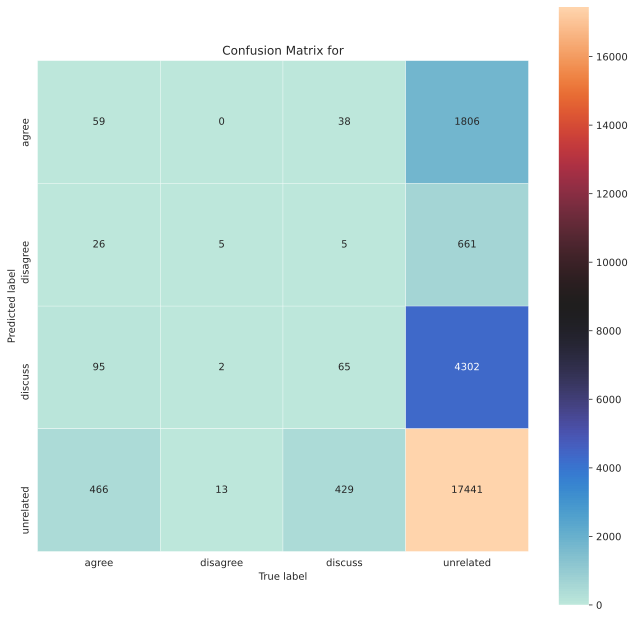

In [266]:
classes = ['agree', 'disagree', 'discuss', 'unrelated']


import seaborn as sns
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [0]:
dt_results = dt_model.predict(features)

In [0]:
mat = confusion_matrix(results,df_test.Stance)

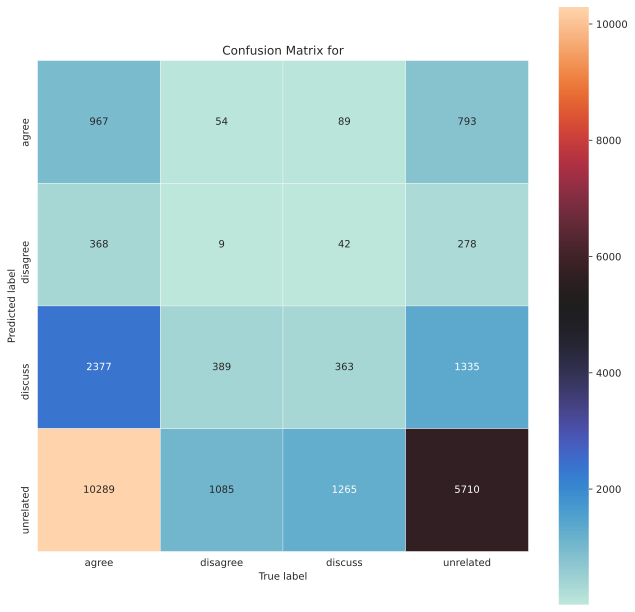

In [239]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [0]:
rf_results = rf_model.predict(combined_TFIDF_test) 

In [0]:
mat = confusion_matrix(rf_results,df_test.Stance)

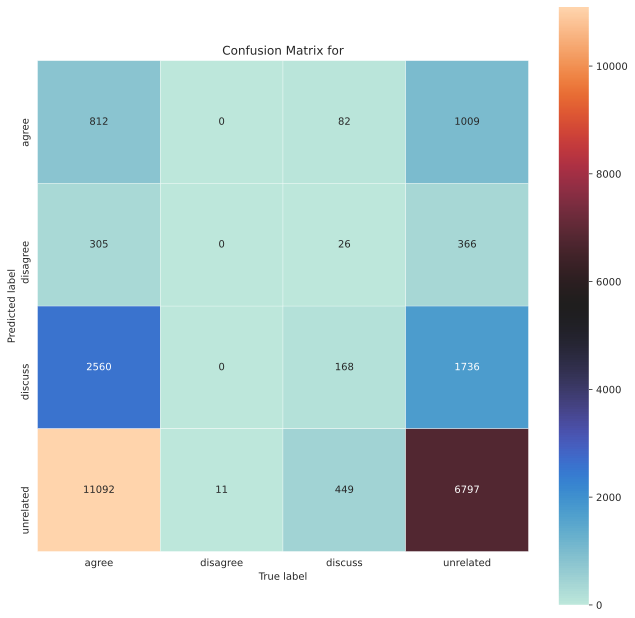

In [270]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [0]:
et_results = et_model.predict(combined_TFIDF_test)

In [0]:
mat = confusion_matrix(et_results,df_test.Stance)

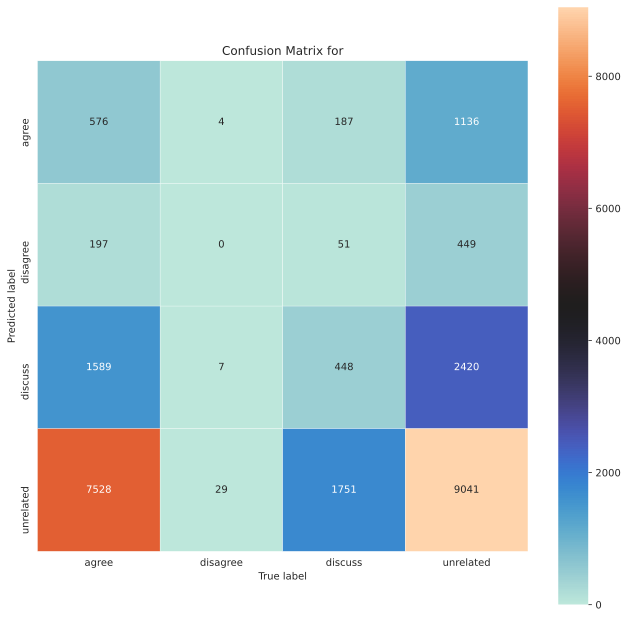

In [274]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [289]:
ensemble_results = model_ensemble.predict_proba(combined_TFIDF_test)

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


In [290]:
ensemble_results

array([[4.38403634e-02, 9.42844815e-04, 5.41576713e-02, 9.01059120e-01],
       [4.72016511e-02, 1.04838429e-03, 1.15316888e-01, 8.36433076e-01],
       [2.31345001e-02, 5.48569794e-04, 5.12225333e-02, 9.25094397e-01],
       ...,
       [1.72756087e-02, 7.44671017e-04, 2.16082600e-01, 7.65897120e-01],
       [6.94678077e-03, 2.42016187e-04, 8.47838030e-01, 1.44973173e-01],
       [1.76245487e-02, 1.05213986e-03, 5.78387946e-01, 4.02935365e-01]])

In [285]:
mat = confusion_matrix(ensemble_results,df_test.Stance)

ValueError: ignored